In [1]:
import numpy as np
import librosa
import librosa.display

from IPython.display import display
from IPython.display import Audio

import pyroomacoustics as pra
from scipy.io import wavfile

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sr, signal = wavfile.read('G:\\speech segregation\\soundly_3rd_seminar-master\\soundly_3rd_seminar-master\\samples\\F01_050C0103_BTH.CH5.wav')
_, noise1 = wavfile.read('G:\\speech segregation\\soundly_3rd_seminar-master\\soundly_3rd_seminar-master\\samples\\BGD_STR_trimmed.wav')
_, noise2 = wavfile.read('G:\\speech segregation\\soundly_3rd_seminar-master\\soundly_3rd_seminar-master\\samples\\BGD_BUS_trimmed.wav')

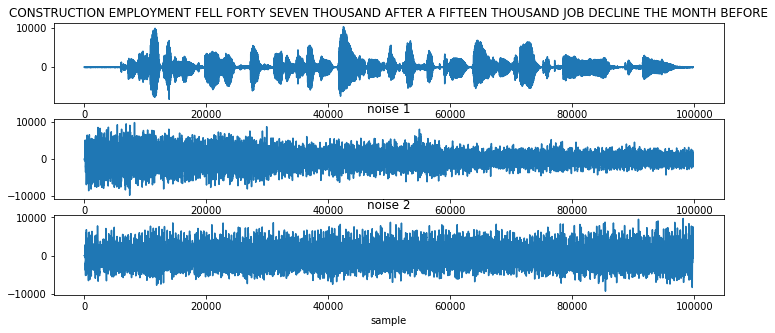

In [4]:
noise1 = noise1[:len(signal)]
noise2 = noise2[:len(signal)]


plt.subplot(3,1,1)
plt.plot(signal)
plt.title('CONSTRUCTION EMPLOYMENT FELL FORTY SEVEN THOUSAND \
AFTER A FIFTEEN THOUSAND JOB DECLINE THE MONTH BEFORE')

plt.subplot(3,1,2)
plt.plot(noise1)
plt.title('noise 1')

plt.subplot(3,1,3)
plt.plot(noise2)
plt.title('noise 2')

plt.xlabel('sample')

#plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(12,5)

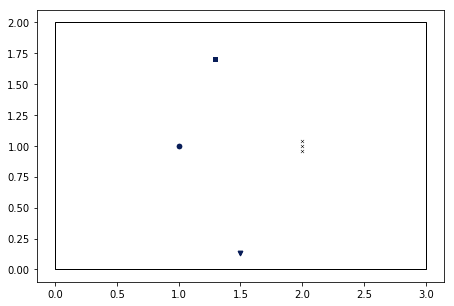

In [5]:
fs = sr
nmic = 3

corners = np.array([[0,0], [0,2], [3,2], [3,0]]).T  # [x,y]

# add source to 2D room
room = pra.Room.from_corners(corners, fs=fs, max_order=1, absorption=1.0)

room.add_source([1.,1.], signal=signal)
room.add_source([2-np.cos(np.pi/4) ,1+np.sin(np.pi/4)], signal=noise1)
room.add_source([2-np.cos(np.pi/3) ,1-np.sin(np.pi/3)], signal=noise2)

R = pra.linear_2D_array(center=[2.,1.], M=nmic, phi=0.5*np.pi, d=0.04)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
fig.set_size_inches(20,5)

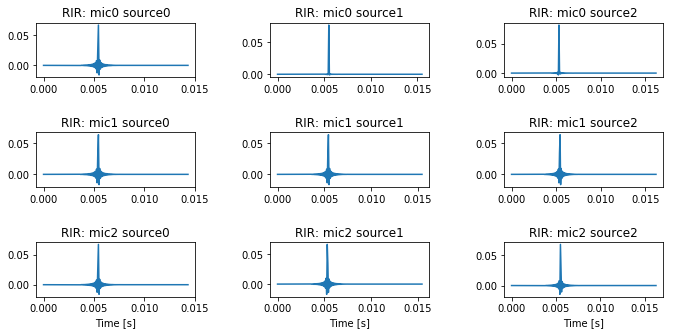

In [6]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(10,5)

In [7]:
# the extra arguments are given in a dictionary
callback_mix_kwargs = {
        'snr' : 100,  # SNR target is 30 decibels
        'sir' : -20,  # SIR target is 10 decibels
        'n_src' : 3,
        'n_tgt' : 1,
        'ref_mic' : 1,
        }

def callback_mix(premix, snr=0, sir=0, ref_mic=0, n_src=None, n_tgt=None):

    # first normalize all separate recording to have unit power at microphone one
    p_mic_ref = np.std(premix[:,ref_mic,:], axis=1)
    premix /= p_mic_ref[:,None,None]

    # now compute the power of interference signal needed to achieve desired SIR
    sigma_i = np.sqrt(10 ** (- sir / 10) / (n_src - n_tgt))
    premix[n_tgt:n_src,:,:] *= sigma_i

    # compute noise variance
    sigma_n = np.sqrt(10 ** (- snr / 10))

    # Mix down the recorded signals
    mix = np.sum(premix[:n_src,:], axis=0) + sigma_n * np.random.randn(*premix.shape[1:])

    return mix

# Run the simulation
room.simulate(
        callback_mix=callback_mix,
        callback_mix_kwargs=callback_mix_kwargs,
        )

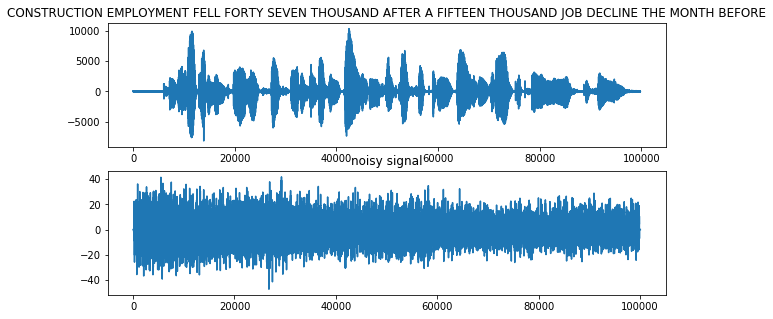

In [8]:
mic_signals = room.mic_array.signals

plt.subplot(2,1,1)
plt.plot(signal)
plt.title('CONSTRUCTION EMPLOYMENT FELL FORTY SEVEN THOUSAND \
AFTER A FIFTEEN THOUSAND JOB DECLINE THE MONTH BEFORE')
plt.subplot(2,1,2)
plt.plot(mic_signals[1,:])
plt.title('noisy signal')

fig = plt.gcf()
fig.set_size_inches(10,5)

display(Audio(signal, rate=sr))
display(Audio(mic_signals[1,:], rate=sr))

In [9]:
nfft=1024

src_pos = room.sources[0].position

dist = np.zeros(nmic)

for m in range(nmic):
    dist[m] = np.sqrt(np.sum((src_pos - [R[0,m], R[1,m]])**2))

print('distance(m):',dist)    
print('TDOA(sec):',(dist-1)/343.0)    
    
freq = np.arange(0, nfft // 2+1) / nfft * float(fs)
h_f = np.exp(-1j * 2 * np.pi * freq[:, np.newaxis] * dist / 343.0)

distance(m): [1.00079968 1.         1.00079968]
TDOA(sec): [2.33142932e-06 0.00000000e+00 2.33142932e-06]


In [10]:
w_f_ds = 1 / nmic * h_f

stft = np.array(list(map(lambda sig: librosa.core.stft(sig, n_fft=nfft), mic_signals)))

enhan_ds_stft = np.zeros((nfft//2+1, np.shape(stft)[2]), dtype=np.complex64)    

for f in range(nfft//2+1):
    for t in range(np.shape(stft)[2]):
        enhan_ds_stft[f,t] = np.inner(w_f_ds[f,:].conj(), stft[:,f,t])

In [11]:
from numpy.linalg import solve

In [12]:
noisy_psd = np.zeros((nfft//2+1, nmic, nmic), dtype=np.complex64)

for f in range(nfft//2+1):
    noisy_psd[f,:,:] = np.matrix(stft[:,f,:]) * np.matrix(stft[:,f,:]).H
    noisy_psd[f,:,:] = noisy_psd[f,:,:] / np.shape(stft)[2]    

w_f_mvdr = np.matrix(np.zeros((nfft//2+1, nmic),dtype=np.complex64))            
    
for f in range(nfft//2+1):
    num = np.matrix(solve(noisy_psd[f,:,:], h_f[f,:]))
    w_f_mvdr[f,:] = num / (np.matrix(h_f[f,:]).conj() * num.T)    

enhan_mvdr_stft = np.zeros((nfft//2+1, np.shape(stft)[2]), dtype=np.complex64)
    
for f in range(nfft//2+1):
    for t in range(np.shape(stft)[2]):
        enhan_mvdr_stft[f,t] = np.inner(w_f_mvdr[f,:].conj(), stft[:,f,t])    
    
enhan_ds = librosa.core.istft(enhan_ds_stft)
enhan_mvdr = librosa.core.istft(enhan_mvdr_stft)

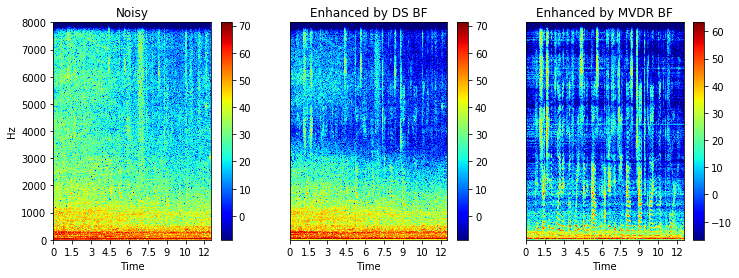

In [13]:
plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft[1,:])), sr=fs, cmap='jet', 
                         x_axis='time', y_axis='linear')
plt.title('Noisy')
plt.colorbar()

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(enhan_ds_stft)), sr=fs, cmap='jet',
                        x_axis='time')
plt.title('Enhanced by DS BF')
plt.colorbar()

plt.subplot(1,3,3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(enhan_mvdr_stft)), sr=fs, cmap='jet',
                        x_axis='time')
plt.title('Enhanced by MVDR BF')
plt.colorbar()

fig = plt.gcf()
fig.set_size_inches(12,4)

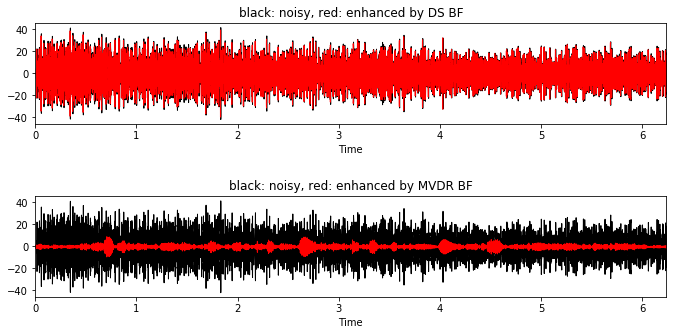

In [14]:
plt.subplot(2,1,1)
librosa.display.waveplot(mic_signals[1,:], sr=fs, color='k')
librosa.display.waveplot(enhan_ds, sr=fs, color='r')
plt.title('black: noisy, red: enhanced by DS BF')
plt.subplot(2,1,2)
librosa.display.waveplot(mic_signals[1,:], sr=fs, color='k')
librosa.display.waveplot(enhan_mvdr, sr=fs, color='r')
plt.title('black: noisy, red: enhanced by MVDR BF')

#plt.tight_layout(pad=1.0)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10,5)

In [15]:
display(Audio(mic_signals[1,:], rate=sr))
display(Audio(enhan_ds, rate=sr))
display(Audio(enhan_mvdr, rate=sr))